# ** Introduction **
> ### **About the dataset** : 
>>### Zillow's Economic Research Team collects, cleans and publishes housing and economic data from a variety of public and proprietary sources. Public property record data filed with local municipalities -- including deeds, property facts, parcel information and transactional histories -- form the backbone of our data products and is fleshed out with proprietary data derived from property listings and user behavior on Zillow.

> ### **About this notebook: ** 
>> ### Zillow Economic Dataset has 20 years of housing price data(1996-2017).This sounds like we can predict the price of next years. Predicting the price given the previous price is called time series analysis. So what is time series analysis? According to Wikipedia, A time series is a series of data points indexed in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

>> ### And to do time series analysis we will use Long short-term memory network or in short LSTM network. So what is LSTM? An LSTM network is a special kind of neural network that can predict according to the data of previous time. It is popular for language recognition, time series analysis and many more.

>> ### In this notebook, I will be using Keras machine learning library as a Tensorflow backend for implementing LSTM.


# ** Table of contents **
> 1. [Load the data](#load_the_data)
> 2. [Pre-process the data](#process_data)
> 3. [Train the model](#train_model)
> 4. [Predict the house price for next years](#predict_house_price)

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

Using TensorFlow backend.


<a id="load_the_data"></a>
# ** 1. Load the data **
> ** For this notebook, I will only use 'City_time_series.csv' file. I will load the file using pandas read_csv method. And keep the mean of ZHVIPerSqft_AllHomes column at same date. Then I will plot the data. **

In [3]:
# load the data using pandas build in read csv function
df_city_time_series = pd.read_csv('../input/City_time_series.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes because we are interested in this column
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
# print the head of our data set
df_city_time_series.head()[['Date','ZHVIPerSqft_AllHomes']]

,Date,ZHVIPerSqft_AllHomes
1,1996-04-30,96.0
2,1996-04-30,76.0
5,1996-04-30,48.0
7,1996-04-30,77.0
9,1996-04-30,57.0


In [4]:
# the ZHVIPerSqft_AllHomes column has many value in same date but for different location. 
# For this notebook we are not interested in location. We mean all the value in same date
df_zhvi_sqft_all = df_city_time_series.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all').ZHVIPerSqft_AllHomes

In [5]:
df_zhvi_sqft_all.head()

Date
1996-04-30    72.056369
1996-05-31    72.021660
1996-06-30    71.979891
1996-07-31    71.976152
1996-08-31    71.964629
Name: ZHVIPerSqft_AllHomes, dtype: float64

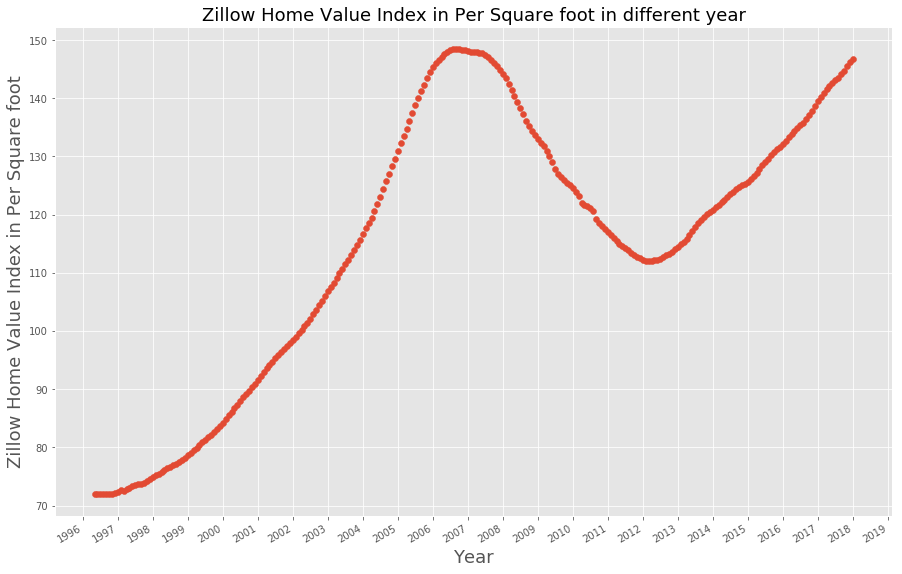

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Zillow Home Value Index in Per Square foot in different year', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('Zillow Home Value Index in Per Square foot', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()

# * **We see that the data set has the housing price from 1996 to 2017. We can use this data to predict the price of 2018 and next years. ** *


<a id="process_data"></a>
# ** 2. Pre-process the data **
> ** In this section, I will prepare the dataset for feeding into LSTM network. Basically, I will do 4 things. **

 > 1.  ** Transform data to stationary ** 
 > 2. ** Transform data to supervised learning **
 > 3. ** Split the data into train and test **
 > 4.  ** Scale the data to (-1,1) **

In [10]:
# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [11]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [12]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size, verbose=0)
	return yhat[0,0]

In [ ]:
# convert our column to pandas series 
series = pd.Series(df_zhvi_sqft_all)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

<a id="train_model"></a>
# ** 3. Train the model **
> ** In this section, I will be training the model using data that we prepare in previous steps. **

In [ ]:
# repeat 30 times
repeats = 30
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

In [ ]:
# report performance
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
# print(results.describe())
# results.boxplot()
# plt.show()

In [ ]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)])
plt.plot(predictions)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

In [ ]:
# last value of our dataset
f = np.array(151.072060)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

<a id="predict_house_price"></a>
# ** 4. Predict the house price for next years **
> ** In this section, I will be prediction the housing price for next years given the the last day price value of data set. And plot the prediction in graph** 

In [ ]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [ ]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)



In [ ]:
rng = pd.date_range('2017-08-31 00:00:00', periods=40, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

In [ ]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
original

In [ ]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'],inplace=True)

In [ ]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

In [ ]:
plt.rc('figure', figsize=(15, 10))


In [ ]:
# df_final.plot(figsize=(15, 5),x_compat=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_final.index, df_final)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Zillow Home Value Index in different year', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Zillow Home Value Index in per Square foot', fontsize=18)
fig.autofmt_xdate()
plt.show()

# ** 5. Decision **
> ** It seems like in 2018 - 2021, the housing price will not increase or decrease so much. In 2018 it will change a very little bit down.**
>> ** How perfect the result is? Well I don't say it's the correct prediction. But gives us an idea. **

>  ** I am new the Data science and machine learning field. If you have found any mistakes and have suggestion feel free to comment. Thank you very much! **